### 라이브러리 불러오기

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [38]:
import time
from glob import glob
from tqdm import tqdm
from scipy import interpolate

In [39]:
# conda install tensorflow

In [40]:
# conda install python=3.7

In [91]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, RepeatVector
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

### Arima 조위 / rawdata 조위 데이터셋


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# 데이터 불러오기 
rawdata = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/rawdata.csv')
# for colab
# /content/drive/MyDrive/신입기수 프로젝트/Dataset/rawdata.csv
# for jupyter
# /Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/rawdata.csv

In [44]:
rawdata = rawdata['강화대교_조위']

In [45]:
arima = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/강화대교 조위_처리완료.csv')
arima = arima['강화대교_조위']

In [46]:
nanIndex = rawdata[rawdata.isnull()==True].index

In [47]:
len(nanIndex)

4927

In [48]:
unconsecutive = []
consecutive = []

i = 0
while i < len(nanIndex):
    if nanIndex[i]+1 in nanIndex: # 다음 거가 nanIndex 안에 있으면 다음 거까지 consecutive에 추가
        consecutive.extend([nanIndex[i], nanIndex[i+1]])
        try:
            i += 2
        except: #i가 len(nanIndex2) - 1
            break
    elif nanIndex[i]-1 in nanIndex: #다음 거는 nanIndex 안에 없지만 consecutive로 들어가야 하는 경우(반복 구간의 마지막 원소)
        consecutive.append(nanIndex[i])
        i += 1
    else:
        unconsecutive.append(nanIndex[i])
        i += 1

# consecutive 내에서 구간별로 분리
dummy = []
consecutive2 = [] # 2차원 consecutive
for i in consecutive: 
    dummy.append(i)
    if i+1 not in consecutive:
        consecutive2.append(dummy)
        dummy= []  

In [49]:
print(len(consecutive) + len(unconsecutive) == len(nanIndex) )

True


In [50]:
len(sum(consecutive2, [])) == len(consecutive)

True

In [51]:
# CNN으로 처리할 인덱스
lst1 = consecutive2[0]
lst2 = consecutive2[-2]
print(len(lst1), len(lst2))

698 2536


In [52]:
# lst1에 사용할 학습데이터
# lst1[0]-len(lst1)-w
print(arima.iloc[:lst1[0]]) # 결측치 첫 번째 인덱스 포함 안됨 -> 사용
print(arima.loc[:lst1[0]]) # 결측치 첫 번째 인덱스 포함됨 -> 사용 안함

# window size
w = 6

# 마지막 len(lst1)+w 만큼은 학습데이터에 사용 못함(xtest에 포함시켜야 함)
x = arima.iloc[:lst1[0]-len(lst1)-w+1]
x

0       445.0
1       449.0
2       451.0
3       452.0
4       450.0
        ...  
1372    353.0
1373    338.0
1374    323.0
1375    310.0
1376    307.0
Name: 강화대교_조위, Length: 1377, dtype: float64
0       445.000000
1       449.000000
2       451.000000
3       452.000000
4       450.000000
           ...    
1373    338.000000
1374    323.000000
1375    310.000000
1376    307.000000
1377    308.064465
Name: 강화대교_조위, Length: 1378, dtype: float64


0      445.0
1      449.0
2      451.0
3      452.0
4      450.0
       ...  
669    446.0
670    474.0
671    504.0
672    533.0
673    559.0
Name: 강화대교_조위, Length: 674, dtype: float64

In [53]:
# train, test data 생성할 때 필요
from sklearn.model_selection import train_test_split
# 정규화할 때 필요
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# input 정규화
x_regular = x.copy()

scaler = StandardScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
a=np.array(x_regular)
tmp_x = scaler.fit_transform(a.reshape(-1,1))
x_regular = tmp_x

In [54]:
len(x_regular)

674

In [55]:
x_regular[0:1]

array([[0.76961315]])

In [56]:
y_predict = []

xtrain = []
ytrain = []

for i in tqdm(range(len(x_regular)-w)):
    xtrain.append(np.array(x_regular[i:i + w]).astype(float))
for i in tqdm(range(w, len(x_regular))):
  ytrain.append(np.array(x_regular[i]).astype(float))

100%|██████████| 668/668 [00:00<00:00, 314737.71it/s]


In [57]:
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)
print(xtrain.shape)
print(ytrain.shape)

(668, 6, 1)
(668, 1)


In [58]:
xtest = []
for i in tqdm(range(len(x), lst1[0]-w)):
  xtest.append(np.array(arima[i:i+w]).astype(float))

100%|██████████| 697/697 [00:00<00:00, 5614.55it/s]


In [59]:
# validation data 생성

x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size = 0.2, random_state = 0)

In [60]:
x_train.shape

(534, 6, 1)

In [61]:
# 모델링 및 모델 학습

if 'model' in locals(): 
    del model 
if 'history' in locals():
    del history


#He_normal
He_normal = keras.initializers.he_normal(seed=None)

model = Sequential()
model.add(Conv1D(filters = 8, input_shape = (w, 1), kernel_size = 2, padding='causal', dilation_rate=2, kernel_initializer = He_normal))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))  #0.2~0.5  0.8까지

model.add(AveragePooling1D(pool_size=2))
model.add(Flatten())

model.add(RepeatVector(1))
model.add(LSTM(100, activation='relu'))

model.add(Dense(100, activation='relu'))
model.add(Dense(1))


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

opt = tf.keras.optimizers.Adam(lr=0.005) #기본값 0.001
model.compile(optimizer=opt, loss=root_mean_squared_error, metrics =["accuracy"])
model.summary()



callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=15),
                keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                monitor='val_loss',
                                                save_best_only=True)]



history = model.fit(xtrain, ytrain, epochs=300, validation_data = (x_val, y_val), verbose=1, callbacks=callbacks, batch_size = 3742) #batch size..?


keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

keras_model_best.evaluate(x_val,y_val)

# y_predict.append(keras_model_best.predict(xtest))
start = time.time()
print("time :", time.time() - start, "초")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 6, 8)              24        
                                                                 
 batch_normalization_3 (Batc  (None, 6, 8)             32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 6, 8)              0         
                                                                 
 dropout_3 (Dropout)         (None, 6, 8)              0         
                                                                 
 conv1d_4 (Conv1D)           (None, 6, 16)             272       
                                                                 
 batch_normalization_4 (Batc  (None, 6, 16)            64        
 hNormalization)                                      

In [62]:
xtest = np.array(xtest).reshape(697, 6, 1)

In [63]:
y_predict = keras_model_best.predict(xtest)

In [64]:
y_predict.shape

(697, 1)

In [65]:
y_predict = y_predict.reshape(697,)
y_predict

array([547.9196  , 561.35675 , 571.346   , 578.1564  , 581.43207 ,
       580.87897 , 576.74805 , 568.9968  , 558.636   , 545.7915  ,
       531.98456 , 516.5737  , 500.7778  , 484.55838 , 467.572   ,
       450.56296 , 433.7112  , 417.20306 , 400.97906 , 385.20294 ,
       370.00558 , 354.78738 , 339.8182  , 325.30585 , 311.2613  ,
       297.81772 , 284.77206 , 272.24054 , 260.1993  , 248.53172 ,
       237.26176 , 226.46098 , 216.15892 , 206.04103 , 196.3543  ,
       187.0424  , 177.98079 , 169.13795 , 160.57515 , 151.96176 ,
       143.82149 , 135.81767 , 127.885765, 120.474884, 112.97557 ,
       105.96135 ,  99.214424,  93.14992 ,  88.36993 ,  86.3441  ,
        89.015945,  94.98134 , 105.83057 , 120.68428 , 138.04616 ,
       153.54951 , 167.09819 , 180.11995 , 193.99278 , 209.17827 ,
       227.12038 , 247.45549 , 270.59042 , 295.88223 , 322.85742 ,
       351.65488 , 381.53238 , 411.40823 , 442.0967  , 472.59354 ,
       502.58795 , 531.75397 , 558.1812  , 582.23706 , 603.123

In [66]:
arima.iloc[lst1[0] : lst1[-1]] = y_predict

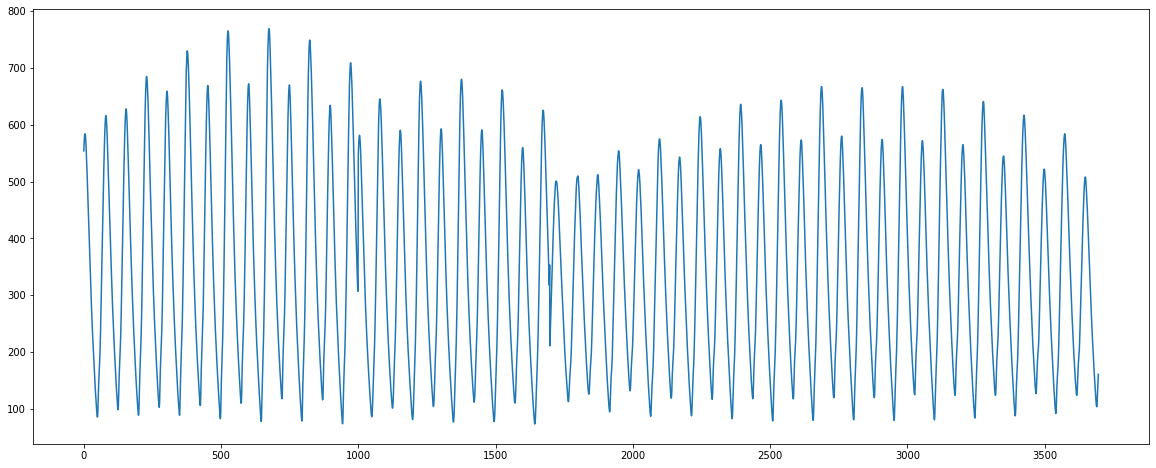

In [67]:
plt.figure(figsize=(20,8))

start  = lst1[0] -1000
end = lst1[-1] + 2000

x1 = range(len(arima[start : end]))
y1 = arima[start:end]
plt.plot(x1, y1)

In [69]:
arima.isnull().sum()

0

In [68]:
# 1번째 구간밖에 안했지만 임시로 저장하기
# arima.to_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/CNN_전처리/강화대교_조위.csv', index = False, encoding = 'cp949')

In [78]:
len(lst2)

2536

In [79]:
# lst1에 사용할 학습데이터
# lst1[0]-len(lst1)-w

# window size
w = 3

# 마지막 len(lst1)+w 만큼은 학습데이터에 사용 못함(xtest에 포함시켜야 함)
x2 = arima.iloc[:lst2[0]-len(lst2)-w+1]
len(x2)

259886

In [80]:
# train, test data 생성할 때 필요
from sklearn.model_selection import train_test_split
# 정규화할 때 필요
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# input 정규화
x2_regular = x2.copy()

scaler = StandardScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
a2=np.array(x2_regular)
tmp_x2 = scaler.fit_transform(a2.reshape(-1,1))
x2_regular = tmp_x2

In [84]:
y_predict2 = []

xtrain2 = []
ytrain2 = []

for i in tqdm(range(len(x2_regular)-w)):
  xtrain2.append(np.array(x2_regular[i:i + w]).astype(float))
for i in tqdm(range(w, len(x2_regular))):
  ytrain2.append(np.array(x2_regular[i]).astype(float))

100%|██████████| 259883/259883 [00:00<00:00, 600848.61it/s]


In [85]:
print(len(xtrain2))
print(len(ytrain2))

259883
259883


In [86]:
xtrain2 = np.array(xtrain2)
ytrain2 = np.array(ytrain2)
print(xtrain2.shape)
print(ytrain2.shape)

(259883, 3, 1)
(259883, 1)


In [88]:
xtest2 = []
for i in tqdm(range(len(x2), lst2[0]-w+1)):
  xtest2.append(np.array(arima[i:i+w]).astype(float))

100%|██████████| 2536/2536 [00:00<00:00, 10366.91it/s]


In [95]:
xtest2 = np.array(xtest2).reshape(len(xtest2), 3, 1)

In [90]:
# validation data 생성

x_train2, x_val2, y_train2, y_val2 = train_test_split(xtrain2, ytrain2, test_size = 0.4, random_state = 0)

In [92]:
# 모델링 및 모델 학습

if 'model' in locals(): 
    del model 
if 'history' in locals():
    del history


#He_normal
He_normal = keras.initializers.he_normal(seed=None)

model = Sequential()
model.add(Conv1D(filters = 8, input_shape = (w, 1), kernel_size = 2, padding='causal', dilation_rate=2, kernel_initializer = He_normal))
model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
model.add(BatchNormalization())

model.add(AveragePooling1D(pool_size=2))
model.add(Flatten())

model.add(RepeatVector(1))
model.add(LSTM(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))


model.add(Dense(1))


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

opt = tf.keras.optimizers.Adam(lr=0.005) #기본값 0.001
model.compile(optimizer=opt, loss=root_mean_squared_error, metrics =["accuracy"])
model.summary()



callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=15),
                keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                monitor='val_loss',
                                                save_best_only=True)]



history = model.fit(x_train2, y_train2, epochs=300, validation_data = (x_val2, y_val2), verbose=1, callbacks=callbacks, batch_size = 3742) #batch size..?


keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

keras_model_best.evaluate(x_val2,y_val2)

# y_predict.append(keras_model_best.predict(xtest))
start = time.time()
print("time :", time.time() - start, "초")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 3, 8)              24        
                                                                 
 conv1d_7 (Conv1D)           (None, 2, 16)             272       
                                                                 
 batch_normalization_6 (Batc  (None, 2, 16)            64        
 hNormalization)                                                 
                                                                 
 average_pooling1d (AverageP  (None, 1, 16)            0         
 ooling1D)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 16)           

In [94]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 3, 8)              24        
                                                                 
 conv1d_7 (Conv1D)           (None, 2, 16)             272       
                                                                 
 batch_normalization_6 (Batc  (None, 2, 16)            64        
 hNormalization)                                                 
                                                                 
 average_pooling1d (AverageP  (None, 1, 16)            0         
 ooling1D)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 16)           

In [106]:
y_predict2 = keras_model_best.predict(xtest2)

In [107]:
y_predict2 = np.array(y_predict2).reshape(len(y_predict2),)
y_predict2

array([260.96823, 280.60806, 299.14743, ..., 193.30333, 202.84308,
       212.46263], dtype=float32)

In [108]:
arima.iloc[lst2] = y_predict2

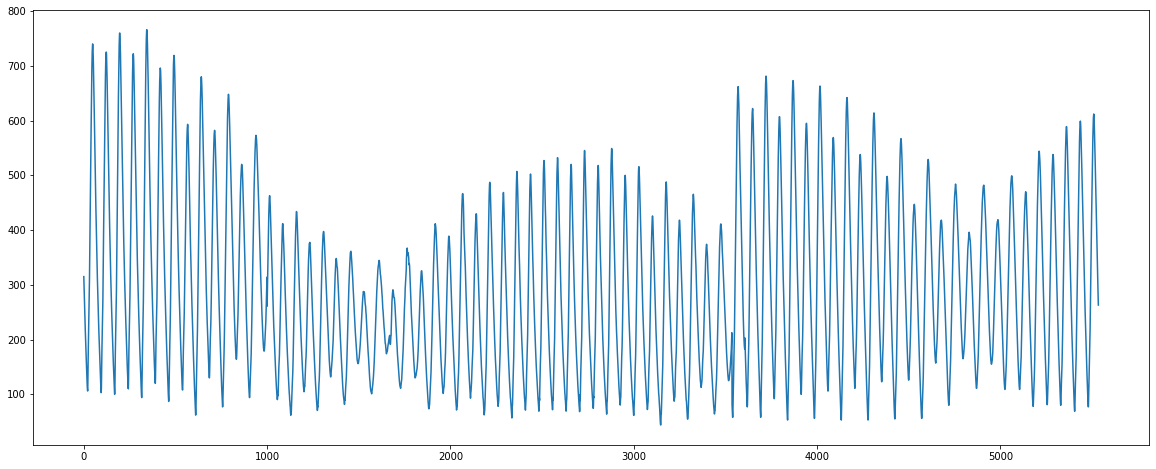

In [109]:
plt.figure(figsize=(20,8))

start  = lst2[0] -1000
end = lst2[-1] + 2000

x1 = range(len(arima[start : end]))
y1 = arima[start:end]
plt.plot(x1, y1)

In [110]:
arima.to_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/CNN_전처리/강화대교_조위.csv', index = False, encoding = 'cp949')